# Phylogenetic HMM for genome annotation

**Implementation of the Gene finder Phylo-HMM model from the article A. Siepel and D. Haussler**

(Siepel, A. and Haussler, D. Phylogenetic hidden markov models.
Statistical Methods in Molecular Evolution, 3(3):325—-351,
2005.)

# I - Phylogenetic model and HMM algorithms

## I.1 - Felsenstein algorithm
Dyn. programming algorithm for efficiently computing the likelihood of observations (alignment of DNA sequences) given a phylogenetic model

In [23]:
import numpy as np
from scipy.linalg import expm

def felsenstein(Q, pi, tree, obs):
    '''Computes the likelihood of an observation, given a phylogenetic tree defined by parameters Q, pi, tree,
    using Felsenstein pruning algorithm.
        Inputs:
            - Q : the subsitution rate matrix.
            - pi : the vector of background frequencies.
            - tree (dict of nodes and children): the phylogenetic tree
            - obs: the observations (alignment of sequences)
        Output:
            -  the likelihood of the observations given the tree.
    '''
    dynamic_probas = {}  # stores the likelihoods already computed at each node.

    nb_nucleotides, n_species = obs.shape
    observation = obs.copy()
    x_index = np.arange(nb_nucleotides)
    #helper function that recursively computes the intermediate likelihoods in the nodes of the tree
    def intlikelihood(node):
        if node in dynamic_probas: # if likelihood of node already computed
            return dynamic_probas[node]
        else:
            childs = tree[node]
            #if node has children (not leaf node)
            if childs: # recursively computes the intermediate likelihoods
                left_child = childs[0]["node"]
                right_child = childs[1]["node"]
                proba_left = intlikelihood(left_child)
                proba_right = intlikelihood(right_child)
                # substitution proba - left child
                subs_prob_left = expm(childs[0]["branch"]*Q)
                # substitution proba - right child
                subs_prob_right = expm(childs[1]["branch"]*Q)
                # computes right and left likelihoods terms
                left_likelihood = subs_prob_left.dot(proba_left.T)
                right_likelihood = subs_prob_right.dot(proba_right.T)
                #likelihood of the parent node 'node'
                return (left_likelihood*right_likelihood).T
            else:
                # leaf node
                likelihood = np.zeros((nb_nucleotides, 4))
                likelihood[x_index, np.floor(
                    observation[:, node - 1]).astype('int')] = 1 # put a 1 in column (0,1,2,3) representing observation (one hot encoding)
                return likelihood
    # Felsenstein algo - fill the dynamic programming table with the computed intermediate likelihoods of each node
    for node in tree:
        dynamic_probas[node] = intlikelihood(node)
    # return the likelihood of the root (= max key of the tree)
    return dynamic_probas[max(tree.keys())].dot(pi)

## I.2 - Viterbi algorithm

Dynamic programming algo for computing the maximum likelihood path, given observations in a HMM

In [24]:
def log_alpha_recursion(X, A, log_eps, pi) :
    """
    (Log) alpha recursion for a time-homogeneous HMM with Gaussian emissions

    Inputs:
        X: [Tx2] matrix of observations
        A: [KxK] transition matrix
        log_eps: [TxK] matrix of log emission probabilities:
        pi: [Kx1] initial latent state distribution

    Returns:
        log_alpha: [TxK] vector containing log p(z_t , x_{1:t})
    """
    T, K = log_eps.shape

    #Initialization
    log_alpha = np.zeros((T, K))
    log_alpha[0,:] = log_eps[0,:] + np.log(pi)


    for t in range(1, T):
        for k in range(K):  # Loop over states
            # Compute log-sum-exp for previous states
            max_val = np.max(log_alpha[t-1, :] + np.log(A[k,:]))  # isolate the max for numerical stability
            log_sum_exp = max_val + np.log(np.sum(np.exp(log_alpha[t-1, :] + np.log(A[k,:]) - max_val)))
            log_alpha[t, k] = log_eps[t, k] + log_sum_exp

    return log_alpha

def log_beta_recursion(X, A, log_eps) :
    """
    (Log) beta recursion for a time-homogeneous HMM with Gaussian emissions

    Inputs:
        X: [Tx2] matrix of observations
        A: [KxK] transition matrix
        log_eps: [TxK] matrix of log emission probabilities: log p(x_t | z_t = k)

    Returns:
        log_beta: [TxK] vector containing log p(x_{t+1:T} | z_t)
    """
    T, K = log_eps.shape
    log_beta = np.zeros((T,K))
    #Initialization
    log_beta[T-1,:] = 0 # (as beta = 1 in final step and log(1)= 0 )

    # Recursion
    for t in range(T-2, -1, -1):  # Loop backward from T-2 to 0
        for k in range(K):  # Loop over current states
            # Compute log-sum-exp for next states
            max_val = np.max(log_eps[t+1, :] + np.log(A[:, k]) + log_beta[t+1, :])  # isolate the max for numerical stability
            log_sum_exp = max_val + np.log(
                np.sum(np.exp(log_eps[t+1, :] + np.log(A[:, k]) + log_beta[t+1, :] - max_val))
            )
            log_beta[t, k] = log_sum_exp
    return log_beta


def viterbi (A, b,log_eps):
    """
    Viterbi decoding for HMM

    Inputs:

        b: [Kx1] initial latent state distribution
        A: [KxK] transition matrix
        log_eps: [TxK] matrix of log emission probabilities

    Returns:
        z: [TxK] one-hot encoding of most probable state sequence z_{1:T} given x_{1:T}
    """

    T, K = log_eps.shape

    # dynamic programming table V and Traceback of maximum states
    V = np.zeros((T, K))  # V[t, k] stores the max log - probability of path z_1 ... z_t ending in state k at time t
    traceback = np.zeros((T, K), dtype=int)  # traceback the states corresponding to argmax, to enable retracing the max lilklihood path.

    # Initialization
    for k in range(K):
        V[0, k] = np.log(b[k]) + log_eps[0, k]  # log probabilities
        traceback[0, k] = -1  # No traceback for the first step

    # Recursion step
    for t in range(1, T):
        for k in range(K):
            # Compute the maximum log-probability for reaching state k at time t
            max_prob = -np.inf
            max_state = 0
            for j in range(K):
                prob = V[t - 1, j] + np.log(A[j, k]) + log_eps[t, k]
                if prob > max_prob:
                    max_prob = prob
                    max_state = j
            V[t, k] = max_prob
            traceback[t, k] = max_state



    # Termination step
    z = np.zeros((T, K), dtype=int) # initialize most probable path to 0s
    #Find the final state with the highest probability
    z[T-1, np.argmax(V[T-1,:])] = 1

    # Backtracking step
    for t in range(T - 2, -1, -1):
        z[t, traceback[t + 1, np.argmax(z[t + 1,:])]] = 1

    return z

# II - Simulation algorithms

## Step1 - Synthetic data generation

In [25]:
import numpy as np
from scipy.linalg import expm
from copy import deepcopy
import argparse

def generate_data(A, b, pi, kappa,
                  trees, number_of_nucleotids):
    """
    Generate a synthetic dataset with aligned DNA sequences between species of a phylo tree,  and the list of Ground truth states
    Args :
           - A (np array : nbState, nbState) state transition matrix
           - b (np array: nbState) initial states probability
           - pi (np array : nbState, alphabetSize) nucleotids background
            frequencies, for each hidden state
           - kappa (nparray: size nbState) translation vs transversion rate per state
           - tree (dict) phylogenetic tree topology
           - number_of_nucleotids (int) number of nucleotid in each DNA sequence
    returns :
           - sequences (list of np array: npSpecies, number_of_nucleotids) list of sequences of nucleotids, one for each species
           - states (np array: number_of_nucleotids) list of ground
               truth states for each sie
    """
    Q = rates_HKY(pi, kappa)

    # step1: Generate hidden states
    states = generate_states(A, b, number_of_nucleotids)
    # step2: generate ancestral sequence
    X = generate_ancestral_seq(pi, states)
    # step 3: make the ancestral sequence evolve along the tree --> nspecies sequences
    sequences = evolution(X, states, trees, Q)
    return sequences, states

def generate_states(A, b, nbNucleotids):
    ''' Generate a path of ground truth states using the initial state probas and the transition matrix
        Args:
            - A (np matrix) state transition matrix
            - b (nparray) initial probas for the hidden states
            - nbNucleotids (int) length of the DNA sequence to generate
        Output:
            - np.array of int from 0 to nbState-1
    '''
    states = np.empty(nbNucleotids, dtype=np.uint8)
    nbState = A.shape[0]

    # draw the first state using probas in b
    cumul = np.cumsum(b)
    x = np.random.rand(1)[0]
    index = 0
    while x > cumul[index]:
        index += 1
    states[0] = index

    # draw next state using the state transition matrix
    for i in range(nbNucleotids-1):
        cumul = np.cumsum(A[states[i]])
        x = np.random.rand(1)[0]
        index = 0
        while x > cumul[index]:
            index += 1
        states[i+1] = index
    return states



def generate_ancestral_seq(pi, states):
    '''Generate the ancestral sequence of nucleotids based on hidden states and background nucleotide frequencies pi
        Args:
            - pi (nparray : nbState, alphabetSize) background nucleotides
            frequencies, for each state
            - states (nparray: nbNucleotids), hidden states for each position inn the sequence
        Output:
            - np.array with values between 0 and 3 (representing nucleotides : A, C, G, T)

    '''
    nbState, alphabetSize = pi.shape
    nbNucleotids = states.shape[0]
    # cumulative probas
    cumsum = np.cumsum(pi, axis=1)
    #generate rdm values
    random_values = np.random.rand(nbNucleotids)
    X = np.zeros(nbNucleotids, dtype=np.uint8)
    # draw nucleotides based on the random values, and the cumulative probas (matrix computation)
    for i in range(alphabetSize):
        X[random_values < cumsum[states, i]] = i
        # set the rdm values lower than cumsum[i] to 1 (to avoid overwriting nucleotides at the next iter)
        random_values[random_values < cumsum[states, i]] = 1
    return X



def rates_HKY(pi, kappa):
    """ substitution rates matrix based on the HKY model - for each states
    Args :
            - pi (np array : nbState, alphabetSize) nucleotids background
            frequencies, for each state
           - kappa (np array, nbStates) translation/transversion rate
    returns : Q (np array: nbStates x alphabetSize x alphabetSize)
    substitution rates matrix for each state
    """
    nbState = len(kappa)
    alphabetSize = pi.shape[1]
    Q = np.zeros((nbState, alphabetSize, alphabetSize))
    for j in range(nbState):
        for i in range(alphabetSize):
            Q[j, i, :] = pi[j]
            Q[j, i, (i + 2) % alphabetSize] *= kappa[j]
            # compute each diagonal term s.t.the rows sums to 0 (sum of proba of substitution for all possible nucle = 1)
            Q[j, i, i] -= np.sum(Q[j, i, :])
    return Q

def evolution(seq, states, tree, Q):
    ''' make the ancestral sequence seq evolve along the phylogenetic tree, using substitution probas Q
        Args:
            - seq (np array):  ancestral sequence of nucleotides
            - tree: Phylogenetic tree
            - states (np array): sequence of states
            - Q (nparray ): substitution rate matrix
        Output:
            - nspecies sequences (1 per tree leaf), after evolution
    '''
    nbState = Q.shape[0]
    alphabetSize = Q.shape[1]
# auxiliary function (recursive) to evolve from 1 node to its children nodes
    def evolve(node, sequence):
        children = tree[node]
        if children: # if not leaf node
            res = []
            for c in range(len(children)):
                new_Q = np.zeros_like(Q)
                # compute probability matrices for every state for  branches
                for j in range(nbState):
                    new_br = tree[node][c]["branch"]
                    new_Q[j] = expm(new_br * Q[j])

                new_strand = np.zeros_like(sequence)
                # the new sequence is drawn randomly from the previous one
                # using the probability matrix
                cumul = np.cumsum(new_Q, axis=2) # cumulative substitution probas new_Q [nb_state * nb nuclotides]
                random_values = np.random.rand(sequence.shape[0]) #draw rdm values for all positions in stands
                # vectorial discrete draw
                for i in range(alphabetSize): # define substitution nucleotide for each state in states, and nucleotide in strand
                    new_strand[random_values < cumul[states, sequence, i]] = i
                    random_values[random_values < cumul[states, sequence, i]] = 1 #set the rdm value to 1
                #go to the next node
                new_child = children[c]["node"]
                res += evolve(new_child, new_strand) # call the function recursively on the new child, and new strand generated
            return res
        else: #leaf node
            return [sequence]
    return evolve(max(tree.keys()), seq) #start the recursive function at root of tree, with initial strand X



## Step2 - Predictions

In [26]:
import random
from copy import deepcopy

import numpy as np

def predict_path(seqs, tree, A, b, pi, kappa):
    '''
    predicts the max likelihood path given an alignment of sequences, using a phylo-HMM model.
    '''

    nbState = A.shape[0]
    n_species = len(seqs)
    number_of_nucleotids = len(seqs[0])

    Qs = rates_HKY(pi, kappa)
    # Compute likelihoods with Felsenstein algorithm
    log_likelihoods = np.zeros((number_of_nucleotids,nbState))
    obs = np.zeros((number_of_nucleotids, n_species))
    for i in range(n_species):
        obs[:, i] = seqs[i]
    for state in range(nbState):
        Q = Qs[state]
        p = pi[state]
        log_likelihoods[:,state] = np.log(felsenstein(Q, p, tree, obs))

    # Viterbi algo
    return viterbi(A, b, log_likelihoods)


def predict_path_HMM(seqs, A, b, pi):
    '''
   predicts the max likelihood path given an alignment of sequences, using a standard HMM model.
    '''

    nbState = A.shape[0]
    number_of_nucleotids = len(seqs[0])
    n_species = len(seqs)
    obs = np.zeros((number_of_nucleotids, n_species))
    for i in range(n_species):
        obs[:, i] = seqs[i]
    log_likelihoods = np.zeros((number_of_nucleotids,nbState))
    for state in range(nbState):
      for k in range(n_species):
        for nuc in range(number_of_nucleotids):
          p = pi[state,int(obs[nuc,k])]
          log_likelihoods[nuc,state] += np.log(p) #add the log likelihood of all species in the the alignments
    # Viterbi algo
    return viterbi(A, b, log_likelihoods)


# function to create a sub tree from original phylogenetic tree, with only a subset of nodes (given in list_of_species)
# used to test the impact of number of species observed on gene prediction accuracy with phylo-HMM

def sub_tree(tree, list_of_species):
    """
    keep only the species specified in a list and return the pruned tree
    Args :
           - tree (dict)
           - list_of_species (list of int) : list of selected nodes in the phylogenetic tree
    """
    #create a copy of original tree, that will be pruned based on selected nodes
    tree_copy = deepcopy(tree)

## auxiliary function that recursively remove or keep the nodes of the tree, based on list of species
    def used_nodes(node):
        children = tree[node]
        if children:  # propagate recursively
            for child in children:
                used_nodes(child["node"])

            for child in children:
                new_child = child["node"]
                if new_child not in list_of_species and not tree_copy[new_child]:
                    # remove child if not used in subtree
                    tree_copy[node].remove(child)
                    # delete unused leaves
                    tree_copy.pop(new_child, None)

    # start the node selectioon at the root of the tree
    used_nodes(max(tree_copy.keys()))

    # merge unused intermediary node (with only one child)
    def merge_unused(node, ancestor_list):
        if(len(tree_copy[node]) == 1):
            child = tree_copy[node][0]["node"]
            # if the child has ancestor : remove node
            if ancestor_list:
                branch_length = tree_copy[node][0]["branch"]
                parent = ancestor_list[0]
                siblings = tree_copy[parent]
                for sibling in siblings:
                    if sibling['node'] == node:
                        sibling['node'] = child
                        sibling['branch'] += branch_length
                # child ancestor = node's ancestor
                merge_unused(child, ancestor_list)
            # if the child has no grand parent but has children
            elif tree_copy[tree_copy[node][0]["node"]]:
                tree_copy[child][0]["branch"] += tree_copy[node][0]["branch"]
                merge_unused(child, [])
            tree_copy.pop(node, None)
        elif len(tree_copy[node]) == 2:
            merge_unused(tree_copy[node][0]["node"], [node] + ancestor_list)
            merge_unused(tree_copy[node][1]["node"], [node] + ancestor_list)

    merge_unused(max(tree_copy.keys()), [])
    tree_renamed = {}

    def rename(node):
        # rename nodes of the pruned tree (to keep all indices <= 2*n -1)
        children = tree_copy[node]
        for child in children:
            child_node = child["node"]
            child["node"] = sorted(tree_copy.keys()).index(child_node)+1
            rename(child_node)  # rename child first
        # rename current node
        node_renamed = sorted(tree_copy.keys()).index(node)+1
        tree_renamed[node_renamed] = tree_copy[node]

    rename(max(tree_copy.keys()))
    return tree_renamed

In [27]:
def compute_metrics(actual_path, predicted_path):
    """
    Compute nucleotide-level sensitivity and specificity

    Args:
        actual_path (list or np.array): True states (e.g., 0 for non-coding, 1 for gene).
        predicted_path (list or np.array): Predicted states (e.g., 0 for non-coding, 1 for gene).

    Returns:
        sensitivity (float): Portion correctly predicted of sites actually in genes.
        specificity (float): Portion correctly predicted of sites predicted to be in genes.

    """
    # Convert to numpy arrays for vectorized operations
    actual_path = np.array(actual_path)
    predicted_path = np.array(predicted_path)

    # Calculate True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((actual_path == 1) & (predicted_path == 1))
    TN = np.sum((actual_path == 0) & (predicted_path == 0))
    FP = np.sum((actual_path == 0) & (predicted_path == 1))
    FN = np.sum((actual_path == 1) & (predicted_path == 0))

    # Calculate metrics
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TP / (TP + FP) if (TP + FP) > 0 else 0

    return sensitivity, specificity



In [28]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

def plot_all_results(sens, spec, sens1, spec1,
                     title="Predictions accuracy with the number of species - PhyloHMM and HMM"):
    n_species = sens.shape[1]  # Determine the number of species from the data

    plt.figure(figsize=(8, 6))  # Adjust figure size
    plt.ylim([0, 1])  # Set Y-axis range
    plt.xlabel('Number of Species')
    plt.ylabel('Accuracy metrics')

    # Plot sensitivity and specificity
    plt.plot(range(1, n_species + 1), sens.mean(axis=0), 'b-', linewidth=1, marker='^', label="Sensitivity- PhyloHMM")
    plt.plot(range(1, n_species + 1), spec.mean(axis=0), 'b-', linewidth=1, marker='o', label="Specificity - PhyloHMM")

    # Plot sensitivity1 and specificity1
    plt.plot(range(1, n_species + 1), sens1.mean(axis=0), 'g--', linewidth=1,marker='^', label="Sensitivity - HMM")
    plt.plot(range(1, n_species + 1), spec1.mean(axis=0), 'g--', linewidth=1,marker='o', label="Specificity- HMM")

    # Add title and legend
    plt.title(title)
    plt.legend(loc="lower right", borderaxespad=1)

    # Show the plot
   # plt.grid()
    plt.show()



# III - Tests on synthetic data

## III.1 - Model Parameters

### HMM model

In [29]:
alphabet = ['A', 'C', 'G','T']
alphabetSize = len(alphabet)
nbState = 4

# transition matrix of the toy gene finder
A = np.zeros((nbState, nbState))
A[0, 1] = 1
A[1, 2] = 1
A[2, 3] = 0.011
A[2, 0] = 1 - A[2, 3]
A[3, 3] = 0.9  # 0.9999 in the paper, increased here to get more genes results in 71 genes for 100000 nucleotide sequences
A[3, 0] = 1 - A[3, 3]

# state initial probability (assume uniform distribution, as in paper)
b = np.array([0.25, 0.25, 0.25, 0.25])

# Nucleotide frequencies for s_1, s_2, s_3, s_4, based on average genome empirical data
pi_2 = np.array([
    [0.35, 0.15, 0.15, 0.35],  # s_1
    [0.20, 0.30, 0.20, 0.30],  # s_2
    [0.26, 0.24, 0.24, 0.26],  # s_3
    [0.30, 0.20, 0.20, 0.30]   # s_4
])
# Nucleotide frequencies for s_1, s_2, s_3, s_4, based on simple phylo-HMM 3 states model (from Siepel and Haussler paper)
pi_1 = np.array([[0.39, 0.12, 0.11,  0.38],
                 [0.32, 0.18,  0.27,  0.23],
                 [0.22, 0.28, 0.28, 0.22],
                 [0.09, 0.42, 0.39, 0.10]])



###Phylogenetic Tree

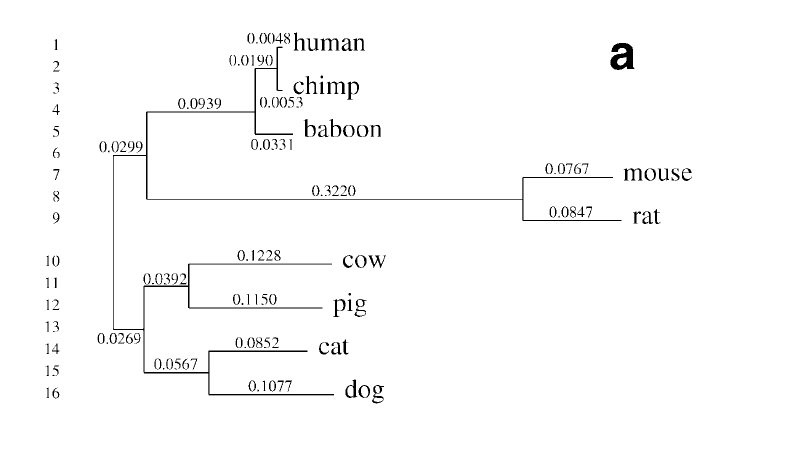

In [30]:
#Phylogenetic model
# Phylogenetic tree structure and branch lengths from Siepel and Haussler paper

tree_a = {
        15: [{"node": 13, "branch": 0.0299}, {"node": 14, "branch": 0.0269}],
        14: [{"node": 11, "branch": 0.0392}, {"node": 12, "branch": 0.0567}],
        13: [{"node": 9, "branch": 0.0939}, {"node": 10, "branch": 0.3220}],
        12: [{"node": 7, "branch": 0.0852}, {"node": 8, "branch": 0.1077}],
        11: [{"node": 5, "branch": 0.1228}, {"node": 6, "branch": 0.1150}],
        10: [{"node": 3, "branch": 0.0767}, {"node": 4, "branch": 0.0847}],
        9: [{"node": 1, "branch": 0.0238}, {"node": 2, "branch": 0.0331}],
        1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []
      }

# transition/transversion rate (transversions more frequent in 3rd codon position and intergenic vs 1st and 2nd codons)
kappa = np.array([2.3, 2.7, 4.3, 5.4])

In [31]:
Qs = rates_HKY(pi_1, kappa)
print(Qs)
print(expm(Qs*0.4))

[[[-0.753  0.12   0.253  0.38 ]
  [ 0.39  -1.374  0.11   0.874]
  [ 0.897  0.12  -1.397  0.38 ]
  [ 0.39   0.276  0.11  -0.776]]

 [[-1.139  0.18   0.729  0.23 ]
  [ 0.32  -1.211  0.27   0.621]
  [ 0.864  0.18  -1.274  0.23 ]
  [ 0.32   0.486  0.27  -1.076]]

 [[-1.704  0.28   1.204  0.22 ]
  [ 0.22  -1.446  0.28   0.946]
  [ 0.946  0.28  -1.446  0.22 ]
  [ 0.22   1.204  0.28  -1.704]]

 [[-2.626  0.42   2.106  0.1  ]
  [ 0.09  -1.02   0.39   0.54 ]
  [ 0.486  0.42  -1.006  0.1  ]
  [ 0.09   2.268  0.39  -2.748]]]
[[[0.76513211 0.03956159 0.07002791 0.12527838]
  [0.12857518 0.59324542 0.03626479 0.2419146 ]
  [0.24828078 0.03956159 0.58687925 0.12527838]
  [0.12857518 0.07639409 0.03626479 0.75876594]]

 [[0.67443952 0.05934239 0.1903917  0.07582639]
  [0.10549759 0.63817026 0.08901359 0.16731857]
  [0.22564942 0.05934239 0.63918179 0.07582639]
  [0.10549759 0.13094496 0.08901359 0.67454386]]

 [[0.56148566 0.09231039 0.27367436 0.07252959]
  [0.07252959 0.62013017 0.09231039 0.215029

## III.2 - Test on 1 sample

### Generate data

In [32]:
# generate sequences for each species
L = 100000
strands, states = generate_data(A, b, pi_2, kappa, tree_a, L)


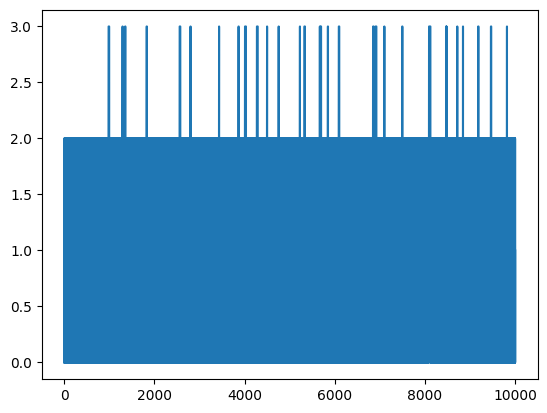

In [33]:
#plot states
import matplotlib.pyplot as plt
plt.plot(states[:10000])

In [34]:
# count number of genes in states (defined by 3 followed by 0)
prev = 0
genes = 0
for i in range(L):
  curr = states[i]
  #print(curr)
  if prev == 3 and curr == 0:
    genes += 1
  prev = curr
print('number of genes in sample: ', genes)


number of genes in sample:  354


In [35]:
#average gene length
gene_length =[]
prev = 0
gene = 0
length = 0
for i in range(L):
  curr = states[i]
  #print(curr)
  if prev == 3 and curr == 0:
    gene += 1
    length = 0
  if curr == 2:
    length += 3 # increment length
  if prev == 2 and curr == 3:
    gene_length.append(length)
  prev = curr
print('average gene length: ', np.mean(gene_length))


average gene length:  272.20338983050846


Print an example of alignment generated

In [36]:
def translate_strand(strand):
    # Map integers to nucleotide bases
    nucleotide_map = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}

    # Translate the strand
    return ''.join([nucleotide_map[i] for i in strand])

In [37]:
for i in range(len(strands)):
  print(translate_strand(strands[i])[:35])
#  print(states[:35])

TTTTTAATCTTGAGATTATTTATGTTGTTTATAGA
TCTTTAATCTTGAGATTATCTATGTCGTCTTCAGA
TCCTCTACCCATAGAATATATCCATTTCTTTCGGT
TACTCTACCTAAAGGCTGTACCCATTTCTCTCAGT
TTTTTAATCTAGAGGTTATATCTATTGATTTTGAA
CCTTCAACCTAGCGGTTGTATCCATCTATTTTGGA
TCTTCAACCTAGAGGTTAGATCGGTTCCCTTTAGA
CCTTCAACTTAGAGGCTAGATCGTTCTCCTTTGGA


### Predict genes

In [38]:
results = {}
strands, states = generate_data(A, b, pi_2, kappa,
                                    tree_a, L)

# Create HKY matrix
Qs = rates_HKY(pi_2, kappa)
# Compute likelihoods with Felsenstein's algorithm
likelihoods = np.zeros((L,nbState))
n_species = 8
seqs = np.zeros((L, n_species))
for i in range(n_species):
  seqs[:, i] = strands[i]
  for state in range(nbState):
        Q = Qs[state]
        p = pi_2[state]
        likelihoods[:,state] = np.log(felsenstein(Q, p, tree_a, seqs))

# Predict genes (Viterbi)
results = {"real_states": states,
           "decoded_states": viterbi(A, b, likelihoods)}


<ipython-input-24-36975b3e1eb5>:91: RuntimeWarning: divide by zero encountered in log
  prob = V[t - 1, j] + np.log(A[j, k]) + log_eps[t, k]


In [39]:
states = results["real_states"]
decoded_states = np.argmax(results["decoded_states"],1)
sens, spec = compute_metrics(states, decoded_states)
print('Sensitivity : ', sens)
print('Specificity : ', spec)

Sensitivity :  0.9950439648281375
Specificity :  0.9925368374051158


## III.3 Impact of nb of species - Phylo-HMM vs HMM

In [40]:
# number of sub trees tested
tests = 8
#simulations
n_simulations = 100
# background nucleotides frequencies
pi = pi_1
# length of DNA sequence generated
L = 1000

#save accuracy results
speci = np.zeros((n_simulations, tests))
sensi = np.zeros((n_simulations, tests))
sensiHMM = np.zeros((n_simulations, tests))
speciHMM = np.zeros((n_simulations, tests))

for n in range(n_simulations):
    strands, states = generate_data(A, b, pi, kappa,
                                    tree_a, L)
    # test impact of number of species
    for i,sub_indices in enumerate(
    [[6],[6,7],[6,7,8],[4,6,7,8],[2,4,6,7,8],[2,3,4,6,7,8],[1,2,3,4,6,7,8],range(1,9)]):

        #redefine sequences according to the subset of species
        strands_n = []
        for j in sub_indices:
          strands_n.append(strands[j-1])

       # adjust the phylogenetic model to the list of species tested
        new_tree=sub_tree(tree_a, sub_indices)
        n_species = len(sub_indices)
        # Predict optimal path - phylo-HMM
        results = predict_path(strands_n, new_tree,A, b, pi, kappa)
        # Predict optimal path - HMM
        results_HMM = predict_path_HMM(strands_n,A,b,pi)
        # Translate optimal paths
        decoded_states = np.argmax(results,1)
        decoded_HMM = np.argmax(results_HMM,1)
        #compute accuracy metrics
        sensi[n, i], speci[n, i] = compute_metrics(states, decoded_states)
        sensiHMM[n,i],speciHMM[n,i] = compute_metrics(states, decoded_HMM)

    print("Simulation n°{:d}".format(n))

<ipython-input-24-36975b3e1eb5>:91: RuntimeWarning: divide by zero encountered in log
  prob = V[t - 1, j] + np.log(A[j, k]) + log_eps[t, k]


Simulation n°0
Simulation n°1
Simulation n°2
Simulation n°3
Simulation n°4
Simulation n°5
Simulation n°6
Simulation n°7
Simulation n°8
Simulation n°9
Simulation n°10
Simulation n°11
Simulation n°12
Simulation n°13
Simulation n°14
Simulation n°15
Simulation n°16
Simulation n°17
Simulation n°18
Simulation n°19
Simulation n°20
Simulation n°21
Simulation n°22
Simulation n°23
Simulation n°24
Simulation n°25
Simulation n°26
Simulation n°27
Simulation n°28
Simulation n°29
Simulation n°30
Simulation n°31
Simulation n°32
Simulation n°33
Simulation n°34
Simulation n°35
Simulation n°36
Simulation n°37
Simulation n°38
Simulation n°39
Simulation n°40
Simulation n°41
Simulation n°42
Simulation n°43
Simulation n°44
Simulation n°45
Simulation n°46
Simulation n°47
Simulation n°48
Simulation n°49
Simulation n°50
Simulation n°51
Simulation n°52
Simulation n°53
Simulation n°54
Simulation n°55
Simulation n°56
Simulation n°57
Simulation n°58
Simulation n°59
Simulation n°60
Simulation n°61
Simulation n°62
Si

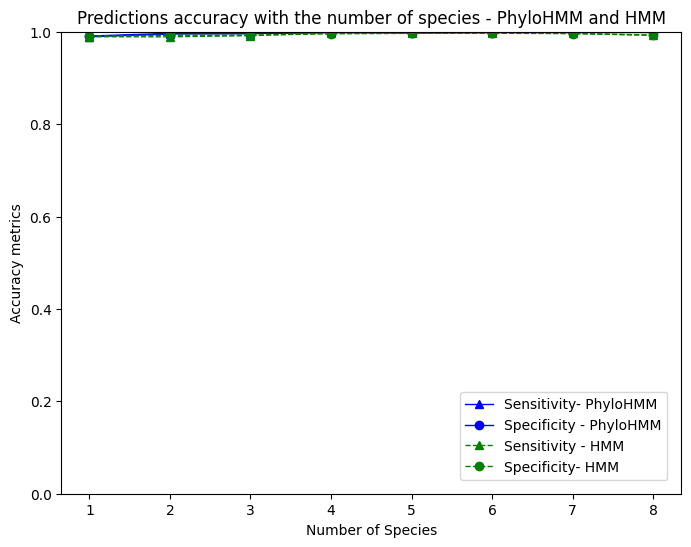

In [41]:
plot_all_results(sensi, speci, sensiHMM, speciHMM)

## III.4 Sensitivity to model parameters

Test the sensitivity to using different background nucleotides frequencies - pi_2

In [42]:
# number of sub trees tested
tests = 8
#simulations
n_simulations = 100
# background nucleotides frequencies
pi = pi_2
# length of DNA sequence generated
L = 1000

#save accuracy results
speci = np.zeros((n_simulations, tests))
sensi = np.zeros((n_simulations, tests))
sensiHMM = np.zeros((n_simulations, tests))
speciHMM = np.zeros((n_simulations, tests))

for n in range(n_simulations):
    strands, states = generate_data(A, b, pi, kappa,
                                    tree_a, L)
    # test impact of number of species
    for i,sub_indices in enumerate(
    [[6],[6,7],[6,7,8],[4,6,7,8],[2,4,6,7,8],[2,3,4,6,7,8],[1,2,3,4,6,7,8],range(1,9)]):

        #redefine sequences according to the subset of species
        strands_n = []
        for j in sub_indices:
          strands_n.append(strands[j-1])

       # adjust the phylogenetic model to the list of species tested
        new_tree=sub_tree(tree_a, sub_indices)
        n_species = len(sub_indices)
        # Predict optimal path - phylo-HMM
        results = predict_path(strands_n, new_tree,A, b, pi, kappa)
        # Predict optimal path - HMM
        results_HMM = predict_path_HMM(strands_n,A,b,pi)
        # Translate optimal paths
        decoded_states = np.argmax(results,1)
        decoded_HMM = np.argmax(results_HMM,1)
        #compute accuracy metrics
        sensi[n, i], speci[n, i] = compute_metrics(states, decoded_states)
        sensiHMM[n,i],speciHMM[n,i] = compute_metrics(states, decoded_HMM)

    print("Simulation n°{:d}".format(n))

<ipython-input-24-36975b3e1eb5>:91: RuntimeWarning: divide by zero encountered in log
  prob = V[t - 1, j] + np.log(A[j, k]) + log_eps[t, k]


Simulation n°0
Simulation n°1
Simulation n°2
Simulation n°3
Simulation n°4
Simulation n°5
Simulation n°6
Simulation n°7
Simulation n°8
Simulation n°9
Simulation n°10
Simulation n°11
Simulation n°12
Simulation n°13
Simulation n°14
Simulation n°15
Simulation n°16
Simulation n°17
Simulation n°18
Simulation n°19
Simulation n°20
Simulation n°21
Simulation n°22
Simulation n°23
Simulation n°24
Simulation n°25
Simulation n°26
Simulation n°27
Simulation n°28
Simulation n°29
Simulation n°30
Simulation n°31
Simulation n°32
Simulation n°33
Simulation n°34
Simulation n°35
Simulation n°36
Simulation n°37
Simulation n°38
Simulation n°39
Simulation n°40
Simulation n°41
Simulation n°42
Simulation n°43
Simulation n°44
Simulation n°45
Simulation n°46
Simulation n°47
Simulation n°48
Simulation n°49
Simulation n°50
Simulation n°51
Simulation n°52
Simulation n°53
Simulation n°54
Simulation n°55
Simulation n°56
Simulation n°57
Simulation n°58
Simulation n°59
Simulation n°60
Simulation n°61
Simulation n°62
Si

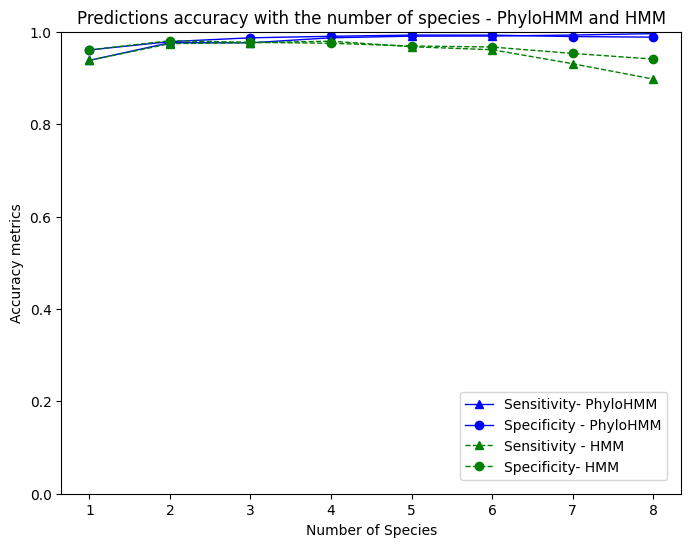

In [43]:
plot_all_results(sensi, speci, sensiHMM, speciHMM)